<a href="https://colab.research.google.com/github/jin-woo-lee/hrtf-interpolation/blob/main/FABIAN_super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare model and dataset

First, clone our git repository.

In [1]:
!git clone https://github.com/jin-woo-lee/hrtf-interpolation.git

Cloning into 'hrtf-interpolation'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 112 (delta 50), reused 96 (delta 34), pack-reused 0
Receiving objects: 100% (112/112), 92.49 MiB | 25.82 MiB/s, done.
Resolving deltas: 100% (50/50), done.


Install dependency. We only require [python-sofa](https://pypi.org/project/python-sofa/), a Python API for reading, writing and creating SOFA files.

In [2]:
!pip install python-sofa

     |████████████████████████████████| 49 kB 4.0 MB/s 
     |████████████████████████████████| 51 kB 481 kB/s 
     |████████████████████████████████| 251 kB 49.3 MB/s 


Next, prepare reference HRTF file in `.sofa` format. You can also download the whole [FABIAN dataset](https://depositonce.tu-berlin.de/handle/11303/6153) and unzip it, but it will take about 20 minutes. The dataset is 1.2 GB in size.
In my case, I will use the `FABIAN_HRIR_modeled_HATO_0.sofa` file that I've prepared.

In [3]:
# uncomment below to download whole dataset!
#!wget https://depositonce.tu-berlin.de/bitstream/11303/6153/9/FABIAN_HRTF_DATABASE_V1.zip
#!unzip FABIAN_HRTF_DATABASE_V1.zip -d FABIAN_HRTF_DATABASE_V1

We will basically use `interp-fabian.py` code under the git repository.
Actually, you can do exactly the same procedure in a bash script like:

```
python3 interp-fabian.py --gpu 0 --test_fold 5 --y_constraint 0 --src $PATH_TO_SOFA_FILE --mesures 1.7,0.82,1.79,2.18,5.99,3.24,0.72,1.16,1.09,0.23,16.4941,27.9157 --scale 6
```
However, to demonstrate inside Colab, we build our in-python `argparse` as something like:


In [11]:
import sys
sys.path.append('hrtf-interpolation')
module = __import__('interp-fabian', fromlist=[''])

class Conf():
    def __init__(self, source, measures):
        self.gpu = 0
        self.ckpt = None
        self.epoch = 100
        self.step = 1485
        self.model = 'hyperfilm'
        self.exp_name = None
        self.in_ch = 16
        self.out_ch = 1
        self.cnn_layers = 5
        self.rnn_layers = 0
        self.batch_size = 64
        self.k_folds = 5
        self.test_fold = 5
        self.p_range = 0.6
        self.rescale = 50
        self.condition = 'hyper'
        self.x_constraint = None
        self.y_constraint = 0.
        self.z_constraint = None
        self.film_dim = 'chan'
        self.scale_factor = 1
        self.save_data = False
        self.show_plot = False
        self.source = source
        self.measures = measures
src = 'FABIAN_HRIR_modeled_HATO_0.sofa'
# src = 'FABIAN_HRTF_DATABASE_V1/1 HRIRs/SOFA/FABIAN_HRIR_modeled_HATO_0.sofa'
mes = [1.7, 0.82, 1.79, 2.18, 5.99, 3.24, 0.72, 1.16, 1.09, 0.23, 16.4941, 27.9157]

conf = Conf(src, mes)
conf.ckpt = "hrtf-interpolation/results/hyperfilm-5x0-Fi_chan-Co_hyper-d_0.6-N_16-5fold5/train/ckpt/100/hyperfilm_1485.pt"

Run the interpolation with scale 1 (no super-resolution).

In [12]:
conf.scale_factor = 1
tar, est_ip = module.interp(conf)

    Interpolation Test: FABIAN
... Load model
...	 Load checkpoint from: hrtf-interpolation/results/hyperfilm-5x0-Fi_chan-Co_hyper-d_0.6-N_16-5fold5/train/ckpt/100/hyperfilm_1485.pt
...	 5-th fold of 5-fold cross-validation
... Load data
[Loader] Gathering neighborhood info


100%|██████████| 180/180 [00:18<00:00,  9.99it/s]


... Test start


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]

[Test] Model RMSE  : 1.6901048024495442 dB
       Linear RMSE : 3.2449889183044434 dB
       Model SD    : 0.9523826638857523 dB
       Linear SD   : 2.073176940282186 dB


Again with scale 6 (super-resolution from scale 1/6 to 1).

In [13]:
conf.scale_factor = 6
tar, est_sr = module.interp(conf)

    Interpolation Test: FABIAN
... Load model
...	 Load checkpoint from: hrtf-interpolation/results/hyperfilm-5x0-Fi_chan-Co_hyper-d_0.6-N_16-5fold5/train/ckpt/100/hyperfilm_1485.pt
...	 5-th fold of 5-fold cross-validation
... Load data
[Loader] Gathering neighborhood info


100%|██████████| 180/180 [00:02<00:00, 60.10it/s]


... Test start


100%|██████████| 3/3 [00:00<00:00, 23.60it/s]

[Test] Model RMSE  : 2.8479833602905273 dB
       Linear RMSE : 3.2449889183044434 dB
       Model SD    : 1.7182518641153972 dB
       Linear SD   : 2.073176940282186 dB


Now let's plot the results. This reproduces the Figure 4 of our paper.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

def plot_hrtf(tar, est_ip, est_sr):
    '''
    tar    : target HRTF; Simulated
    est_ip : estimate HRTF; Ours (x1)
    est_sr : estimate HRTF; Ours (x1/6 to x1)
    '''
    x = np.linspace(0,360,180)
    y = np.linspace(0,22050,129)

    plt.figure(figsize=(5,7),dpi=100)

    plt.subplot(221)
    librosa.display.specshow(tar.T, x_coords=x, y_coords=y,cmap='bwr')
    plt.clim([-20,20])
    plt.xticks(np.arange(0,360,60))
    plt.yticks(np.arange(0,22050,4000))
    # plt.xlabel('Elevation (deg)')
    plt.ylim(0,22050)
    plt.ylabel('Frequency (Hz)')
    plt.title('Simulated')

    plt.subplot(222)
    librosa.display.specshow(est_ip.T, x_coords=x, y_coords=y,cmap='bwr')
    plt.clim([-20,20])
    plt.xticks(np.arange(0,360,60))
    # plt.xlabel('Elevation (deg)')
    plt.title('Ours (x1)')

    plt.subplot(223)
    librosa.display.specshow(tar[0::6].T, x_coords=x[0::6], y_coords=y,cmap='bwr')
    plt.clim([-20,20])
    plt.xticks(np.arange(0,360,60))
    plt.yticks(np.arange(0,22050,4000))
    plt.ylim(0,22050)
    plt.xlabel('Elevation (deg)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Downsampled (x1/6)')

    plt.subplot(224)
    librosa.display.specshow(est_sr.T, x_coords=x, y_coords=y,cmap='bwr')
    plt.clim([-20,20])
    plt.xticks(np.arange(0,360,60))
    plt.xlabel('Elevation (deg)')
    plt.title('Ours (x1/6 to x1)')
    plt.tight_layout()
    plt.savefig('spec.pdf')

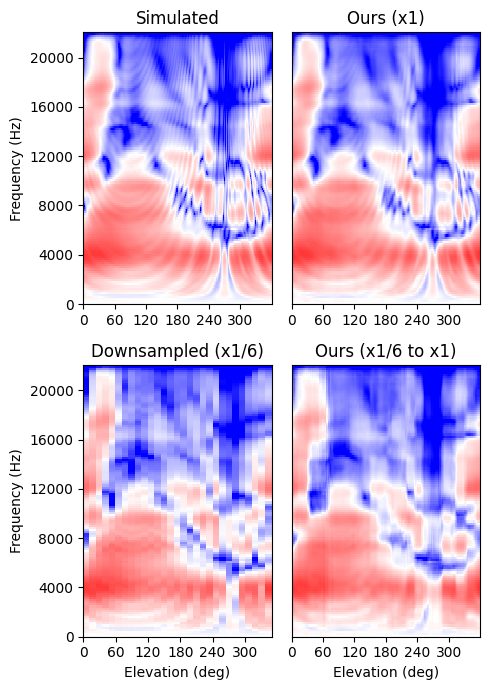

In [15]:
plot_hrtf(tar, est_ip, est_sr)